# Chargement des données

Dans mon projet, j'ai choisi de classifier des images associées à 5 labels différents : **vintage**, **classique**, **gothique**, **streetwear** et **chic**.

J'ai réparti mes images dans 3 ensembles (et donc 3 dossiers): *train*, *validation* et *test*. Chacun de ces dossiers comporte un sous-dossier par classe, qui contient les images correspondantes. L'arborescence est résumée sur l'image ci-dessus.

J'ai choisi d'héberger ma base de données sur Github : l'intérêt est qu'un **git clone** depuis Google Colab est très rapide, ce qui vous garantit une certaine simplicité. Je vous encourage à en faire de même.

In [1]:
!git clone https://github.com/TItygrosminet/Projet_Deep_Learning.git
path = "./Projet_Deep_Learning/src/"

Cloning into 'Projet_Deep_Learning'...
remote: Enumerating objects: 9180, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 9180 (delta 6), reused 9 (delta 2), pack-reused 9163
Receiving objects: 100% (9180/9180), 459.30 MiB | 17.76 MiB/s, done.
Resolving deltas: 100% (92/92), done.
Updating files: 100% (12779/12779), done.


Une fois les données téléchargées localement, on peut maintenant charger les images et les labels. Si vous avez construit votre arborescence de la même manière que la mienne, et que vous adaptez les noms de labels à votre projet, alors le code suivant devrait être utilisable directement.

In [2]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

import cv2


def load_data(data_path, classes, dataset, image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = cv2.imread(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = cv2.resize(img, (image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1
                
    return x, y

Voici ensuite un exemple de chargement de vos données. Notez que vous pouvez modifier la dimension des images, ce qui sera utile à différents stades de votre projet.

In [3]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

image_size=64
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu',input_shape=[image_size,image_size,3]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(5, activation='softmax'))   # Couche de sortie


In [4]:
labels = ['vintage', 'classique', 'gothique', 'streetwear', 'chic']

x, y = load_data(path, labels, dataset='cropped_images', image_size=64)
print(x.shape, y.shape)

# Normalisation des entrées via une division par 255 des valeurs de pixel.
x = x/255

from sklearn.model_selection import train_test_split

x_train, x_gen, y_train, y_gen = train_test_split(x,y, test_size = 3/10)
x_val, x_test, y_val, y_test = train_test_split(x_gen,y_gen, test_size = 1/2)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape


(4230, 64, 64, 3) (4230, 1)


((2961, 64, 64, 3),
 (634, 64, 64, 3),
 (635, 64, 64, 3),
 (2961, 1),
 (634, 1),
 (635, 1))

In [5]:
import pandas as pd

# créer un DataFrame pour stocker les résultats
data = {'classe': labels,
        'train': pd.Series(y_train.ravel()).value_counts(),
        'val': pd.Series(y_val.ravel()).value_counts(),
        'test': pd.Series(y_test.ravel()).value_counts()}

df = pd.DataFrame(data)

print(df)

         classe  train  val  test
0.0     vintage    566  118   109
1.0   classique    677  149   154
2.0    gothique    615  124   143
3.0  streetwear    615  136   125
4.0        chic    488  107   104


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

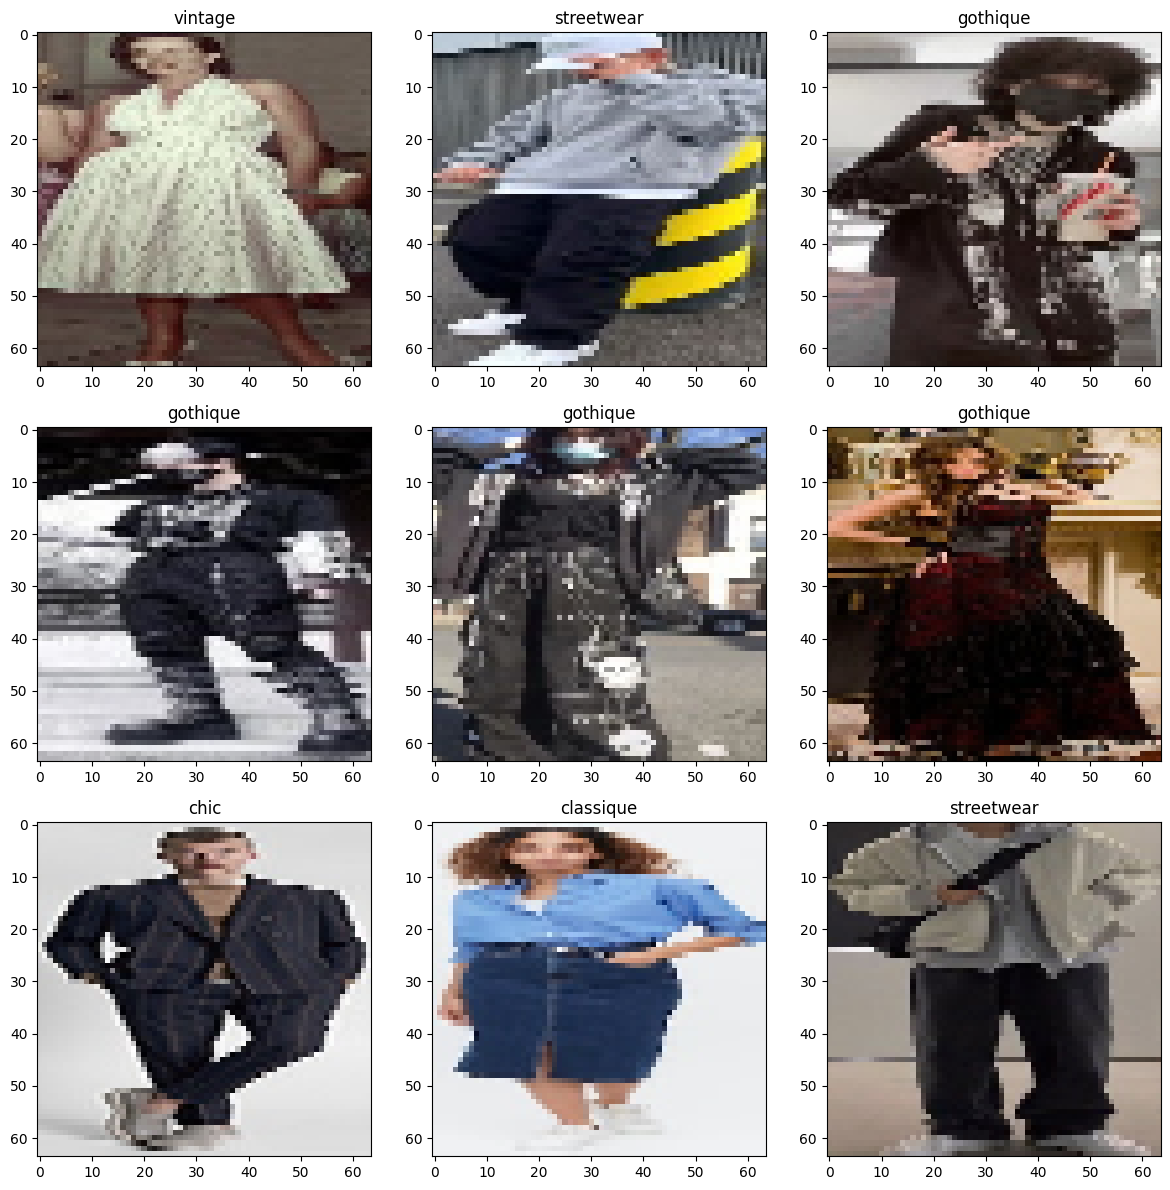

In [6]:
import matplotlib.pyplot as plt
from random import randint
plt.figure(figsize=(12, 12))
shuffle_indices = [randint(0, x.shape[0]) for i in range(9)]
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x[shuffle_indices[i]]
    plt.title(labels[int(y[shuffle_indices[i]])])
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras import optimizers
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 50
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=10, callbacks=[earlystop])

Epoch 1/50
297/297 [==============================] - 3s 10ms/step - loss: 0.0665 - accuracy: 0.9770 - val_loss: 2.2123 - val_accuracy: 0.6120
Epoch 2/50
297/297 [==============================] - 2s 6ms/step - loss: 0.0829 - accuracy: 0.9726 - val_loss: 2.2737 - val_accuracy: 0.5962
Epoch 3/50
297/297 [==============================] - 2s 6ms/step - loss: 0.0547 - accuracy: 0.9875 - val_loss: 2.1945 - val_accuracy: 0.5994
Epoch 4/50
297/297 [==============================] - 1s 5ms/step - loss: 0.0497 - accuracy: 0.9872 - val_loss: 2.4216 - val_accuracy: 0.5931
Epoch 5/50
297/297 [==============================] - 2s 7ms/step - loss: 0.0551 - accuracy: 0.9841 - val_loss: 2.2711 - val_accuracy: 0.6025
Epoch 6/50
297/297 [==============================] - 2s 6ms/step - loss: 0.0565 - accuracy: 0.9818 - val_loss: 2.2787 - val_accuracy: 0.6057
Epoch 7/50
297/297 [==============================] - 2s 6ms/step - loss: 0.0842 - accuracy: 0.9747 - val_loss: 2.2139 - val_accuracy: 0.6151
Epoch

In [9]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

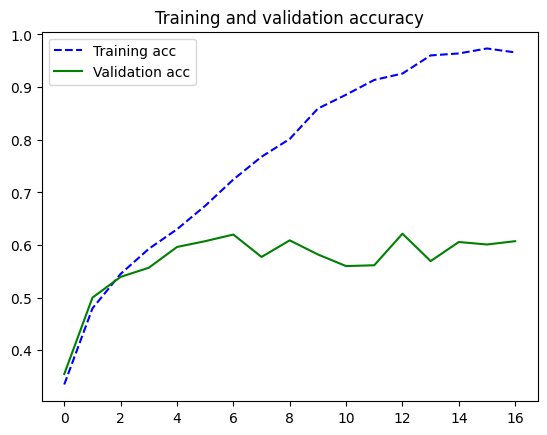

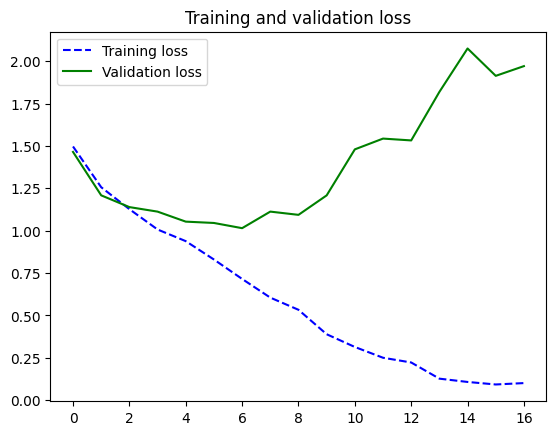

In [10]:
plot_training_analysis()

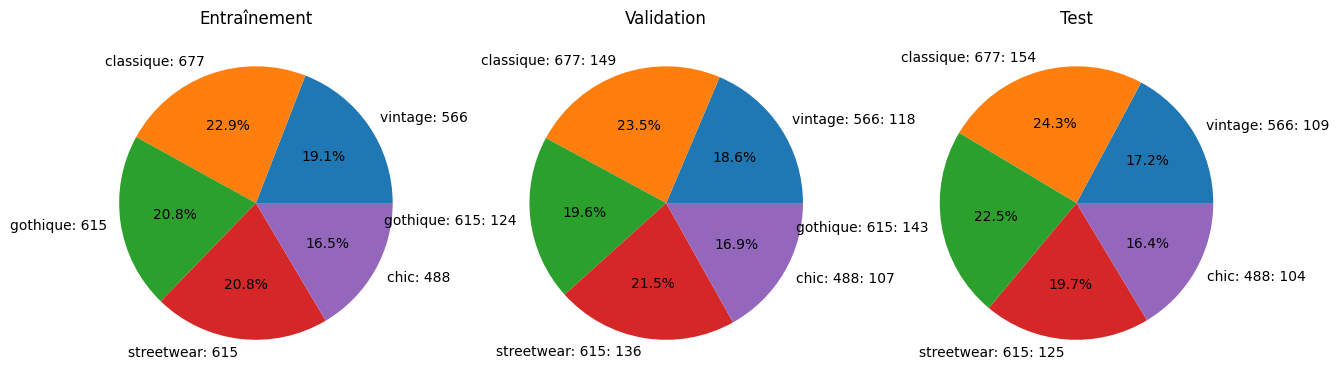

In [11]:
# Nombre d'images par classe
train_counts = np.unique(y_train, return_counts=True)[1]
val_counts = np.unique(y_val, return_counts=True)[1]
test_counts = np.unique(y_test, return_counts=True)[1]

# Création des labels pour l'affichage
labels = ['{}: {}'.format(labels[i], count) for i, count in enumerate(train_counts)]
labels_val = ['{}: {}'.format(labels[i], count) for i, count in enumerate(val_counts)]
labels_test = ['{}: {}'.format(labels[i], count) for i, count in enumerate(test_counts)]

# Affichage des nombres d'images par classe
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].pie(train_counts, labels=labels, autopct='%1.1f%%')
ax[0].set_title('Entraînement')
ax[1].pie(val_counts, labels=labels_val, autopct='%1.1f%%')
ax[1].set_title('Validation')
ax[2].pie(test_counts, labels=labels_test, autopct='%1.1f%%')
ax[2].set_title('Test')
plt.show()

20/20 [==============================] - 1s 10ms/step


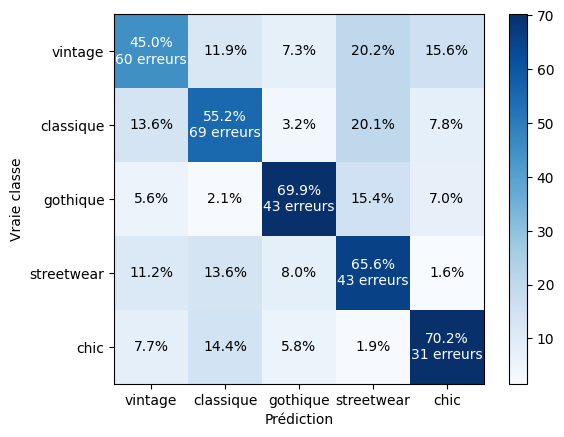

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Prédire les classes sur x_test
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Créer la matrice de confusion
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Calculer les pourcentages
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

# Calculer l'erreur pour chaque classe
classes = ['vintage', 'classique', 'gothique', 'streetwear', 'chic']
errors = []
for i in range(len(classes)):
    errors.append(sum(confusion_mtx[i]) - confusion_mtx[i][i])

# Afficher la matrice de confusion avec les pourcentages et les erreurs
fig, ax = plt.subplots()
im = ax.imshow(confusion_mtx_percent, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel('Prédiction')
ax.set_ylabel('Vraie classe')

# Ajouter les erreurs à la matrice de confusion
for i in range(len(classes)):
    for j in range(len(classes)):
        if i == j:
            ax.text(j, i, '{:.1f}%\n{} erreurs'.format(confusion_mtx_percent[i, j], errors[i]), ha='center', va='center', color='white')
        else:
            ax.text(j, i, '{:.1f}%'.format(confusion_mtx_percent[i, j]), ha='center', va='center', color='black')

plt.show()
